In [1]:
import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

In [2]:
from fastmri.data import transforms as T
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable

from models.utils.utils_torch import virtual_coil_reconstruction, load_and_transform, create_zero_filled_reconstruction
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.models.varnet import VarNet 


In [4]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"

kspace_multicoil = load_and_transform(file_path)
images_multicoil = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil))

image = virtual_coil_reconstruction(images_multicoil)
kspace = torch.fft.fft2(image)

mask_type = "random"
center_fractions = [0.08, 0.04]
accelerations = [4, 8]
mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

zero_filled_reconstruction , masked_data = create_zero_filled_reconstruction(mask,kspace)
zero_filled_reconstruction = torch.fft.fftshift(zero_filled_reconstruction)
print("mask : ",masked_data.shape)


input = zero_filled_reconstruction
target = image.abs().unsqueeze(1)
print("target : ", target.shape)
print("input : ", input.shape)

mask :  torch.Size([1, 640, 1])
target :  torch.Size([16, 1, 640, 320])
input :  torch.Size([16, 1, 640, 320])


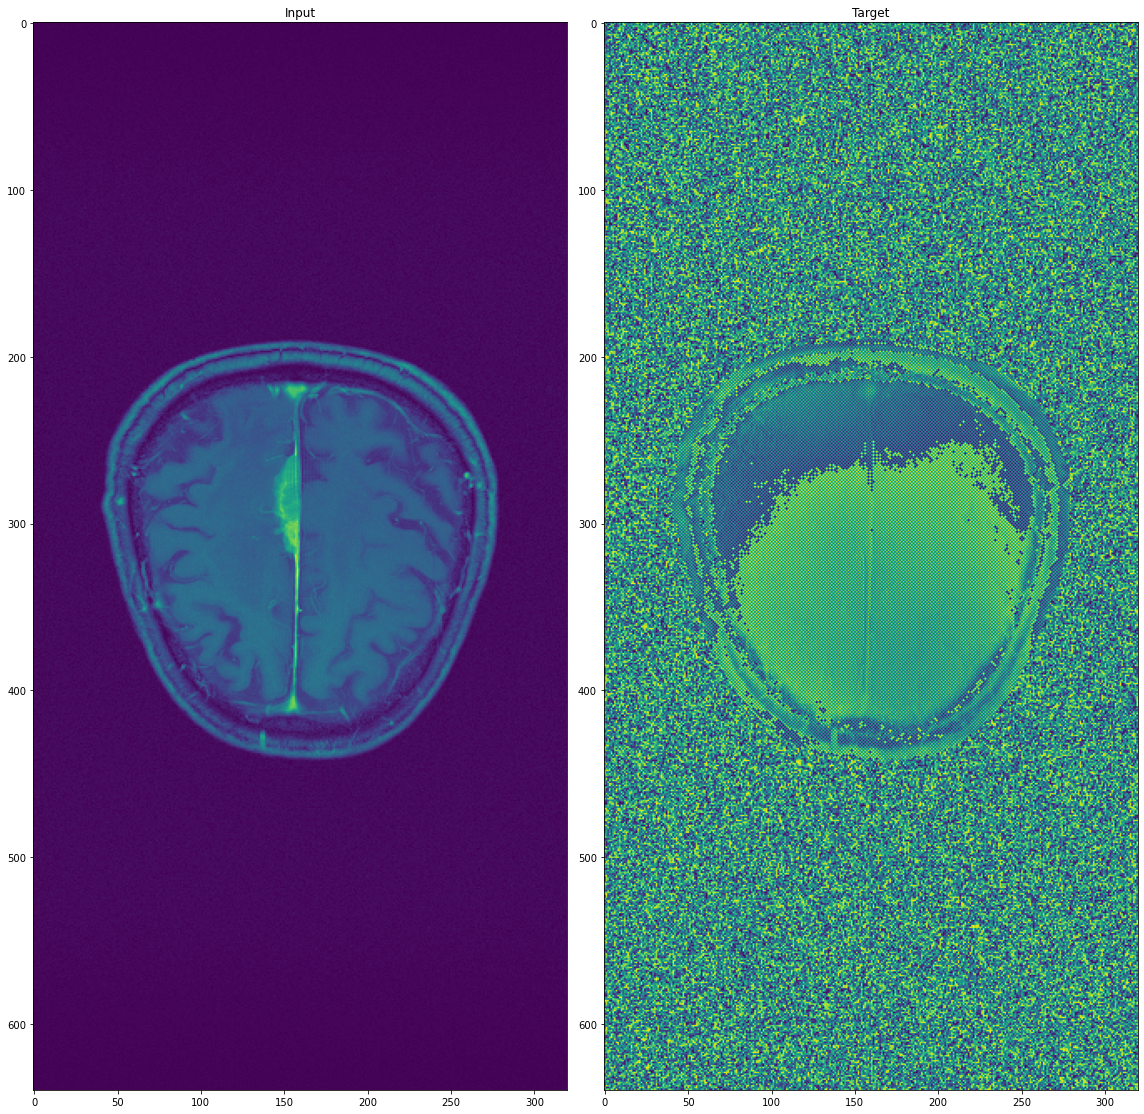

In [17]:
plt.subplot(1,2,1)
plt.imshow(np.abs(image[0]))
plt.title("Input")

plt.subplot(1,2,2)
plt.imshow(np.angle(image[0]))
plt.title("Target")

plt.tight_layout()
plt.show()

In [6]:
chans = 32
num_pool_layers = 4
lr = 0.0001

model = VarNet(chans=chans, pools=num_pool_layers)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_list = []
num_epochs = 1
for epoch in range(num_epochs):
    input = Variable(input)
    target = Variable(target)

    print("out : ", input.shape)
    print("mask : ", masked_data.shape)
    input = input.unsqueeze(-1)
    masked_data = masked_data.unsqueeze(-1)
    masked_data = masked_data.unsqueeze(0)
    print("out : ", input.shape)
    print("mask : ", masked_data.shape)

    optimizer.zero_grad()
    outputs = model(input, masked_data)
    loss = criterion(outputs, target)
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

    # print(f'Epoch [{epoch+1}/{num_epochs}]')

# Sauvegarder le modèle
torch.save(model.state_dict(), 'fastmri_unet_model.pth')


out :  torch.Size([16, 1, 640, 320])
mask :  torch.Size([1, 640, 1])
out :  torch.Size([16, 1, 640, 320, 1])
mask :  torch.Size([1, 1, 640, 1, 1])


IndexError: argmin(): Expected reduction dim 1 to have non-zero size.

In [ ]:
from fastmri.data import transforms

shape = [1, 3, 32, 16, 2]
chans = 32
center_fractions = [0.08]
accelerations = [4]
mask_center = True

def create_input(shape):
    x = np.arange(np.product(shape)).reshape(shape)
    x = torch.from_numpy(x).float()

    return x

mask_func = create_mask_for_mask_type("random", center_fractions, accelerations)
x = create_input(shape)
outputs, masks = [], []
for i in range(x.shape[0]):
    output, mask, _ = transforms.apply_mask(x[i : i + 1], mask_func, seed=123)
    outputs.append(output)
    masks.append(mask)

output = torch.cat(outputs)
mask = torch.cat(masks)

varnet = VarNet(
    num_cascades=2,
    sens_chans=4,
    sens_pools=2,
    chans=chans,
    pools=4,
    mask_center=mask_center,
)
print("out : ", output.shape)
print("mask : ", mask.shape)
print(mask.byte())
y = varnet(output, mask.byte())

/tmp/ipykernel_1098536/976762654.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  x = create_input(shape)


out :  torch.Size([1, 3, 32, 16, 2])
mask :  torch.Size([1, 1, 1, 16, 1])
tensor([[[[[0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [1],
           [0],
           [0],
           [0],
           [0],
           [1],
           [0],
           [0]]]]], dtype=torch.uint8)


In [ ]:
from fastmri.data import transforms

chans = 32
center_fractions = [0.08]
accelerations = [4]
mask_center = True


mask_func = create_mask_for_mask_type("random", center_fractions, accelerations)
x = images_multicoil
outputs, masks = [], []
for i in range(x.shape[0]):
    output, mask, _ = transforms.apply_mask(x[i : i + 1], mask_func, seed=123)
    outputs.append(output)
    masks.append(mask)

output = torch.cat(outputs)
mask = torch.cat(masks)

varnet = VarNet(
    num_cascades=2,
    sens_chans=4,
    sens_pools=2,
    chans=chans,
    pools=4,
    mask_center=mask_center,
)
print("out : ", output.shape)
print("mask : ", mask.shape)
output = output.unsqueeze(-1)
mask = mask.unsqueeze(-1)
print("out : ", output.shape)
print("mask : ", mask.shape)
y = varnet(output, mask.byte())

out :  torch.Size([16, 16, 640, 320])
mask :  torch.Size([16, 1, 640, 1])
out :  torch.Size([16, 16, 640, 320, 1])
mask :  torch.Size([16, 1, 640, 1, 1])


IndexError: argmin(): Expected reduction dim 1 to have non-zero size.